## Linear Regression: Ridge Regression and LASSO

**Functions**

`sklearn.linear_model.RidgeCV`, `sklearn.linear_model.LassoCV`, `sklearn.preprocessing.StandardScaler`


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV

### Exercise 49

Standardize the value-weighted-market return data and the 12 industry portfolios by their standard deviation. You should _not_ remove the mean since we want to match the mean in the tracking portfolio.

In [4]:
vwm = pd.read_csv("data/VWM.csv",index_col="Date")
vwm.index = pd.to_datetime(vwm.index, format="%Y%m")
vwm = vwm.resample("M").last()

industries = pd.read_csv("data/12_Industry_portfolios.csv",index_col="Date")
industries.index = pd.to_datetime(industries.index,format="%Y%m")
industries = industries.resample("M").last()

x = industries["1980":"2014"]
y = vwm["VWM"]["1980":"2014"]
t, p = x.shape

x_scale = x.std(ddof=0)
y_scale = y.std(ddof=0)
std_x = x / x_scale
std_y = y / y_scale

### Exercise 50

Select the optimal tuning parameter in a LASSO and estimate model parameters for the tracking error minimizing portfolio using the standardized data.

In [7]:
# initialise the Lasso CV model
lasso_cv = LassoCV(fit_intercept=False)
lasso_cv = lasso_cv.fit(std_x,std_y)
print(f"Optimal Alpha = {lasso_cv.alpha_}")
lasso_cv.coef_

Optimal Alpha = 0.0009720286574532108


array([ 0.05005624, -0.01018175,  0.09781553,  0.11926269,  0.03592871,
        0.31908609,  0.10457203,  0.0279572 ,  0.06254488,  0.08440358,
        0.17082026,  0.13580386])

### Exercise 51

Transform the estimated LASSO coefficients back to the scale of the original, non-standardized data.

In [8]:
lasso_orig = lasso_cv.coef_ * (y_scale / x_scale)
lasso_orig

NoDur    0.054173
Durbl   -0.006784
Manuf    0.081264
Enrgy    0.094259
Chems    0.035066
BusEq    0.207187
Telcm    0.093599
Utils    0.031835
Shops    0.055549
Hlth     0.081716
Money    0.140461
Other    0.115621
dtype: float64

### Exercise 52

Select the optimal tuning parameter in a Ridge regression and estimate model parameters for the tracking error minimizing portfolio using the standardized data.

In [15]:
ridge_cv = RidgeCV(fit_intercept=False, alphas=np.linspace(1, 100, 100))
ridge_cv = ridge_cv.fit(std_x, std_y)
print(f"Optimal alpha = {ridge_cv.alpha_}")
ridge_cv.coef_

Optimal alpha = 5.0


array([ 0.04783263, -0.01219568,  0.10366898,  0.11818997,  0.03798711,
        0.31163897,  0.10639942,  0.02868318,  0.066685  ,  0.08529813,
        0.16647582,  0.13563203])

In [17]:
ridge_cv = RidgeCV(fit_intercept=False, alphas=np.linspace(4, 6, 2001))
ridge_cv = ridge_cv.fit(std_x, std_y)
print(f"Optimal alpha = {ridge_cv.alpha_}")
ridge_cv.coef_

Optimal alpha = 4.87


array([ 0.04784878, -0.01232701,  0.10364798,  0.11820944,  0.03795449,
        0.31184016,  0.10637149,  0.02868169,  0.06661968,  0.08526424,
        0.16662157,  0.13562156])

### Exercise 53

Transform the estimated Ridge regression coefficients back to the scale of the original, non-standardized data.

In [18]:
ridge_orig = ridge_cv.coef_ * (y_scale / x_scale)
ridge_orig

NoDur    0.051784
Durbl   -0.008213
Manuf    0.086109
Enrgy    0.093426
Chems    0.037043
BusEq    0.202482
Telcm    0.095209
Utils    0.032660
Shops    0.059168
Hlth     0.082549
Money    0.137009
Other    0.115465
dtype: float64

### Exercise 54

Compare the parameter estimates from the LASSO and Ridge regression to those from OLS in a plot. Use the original, non-standardized data.

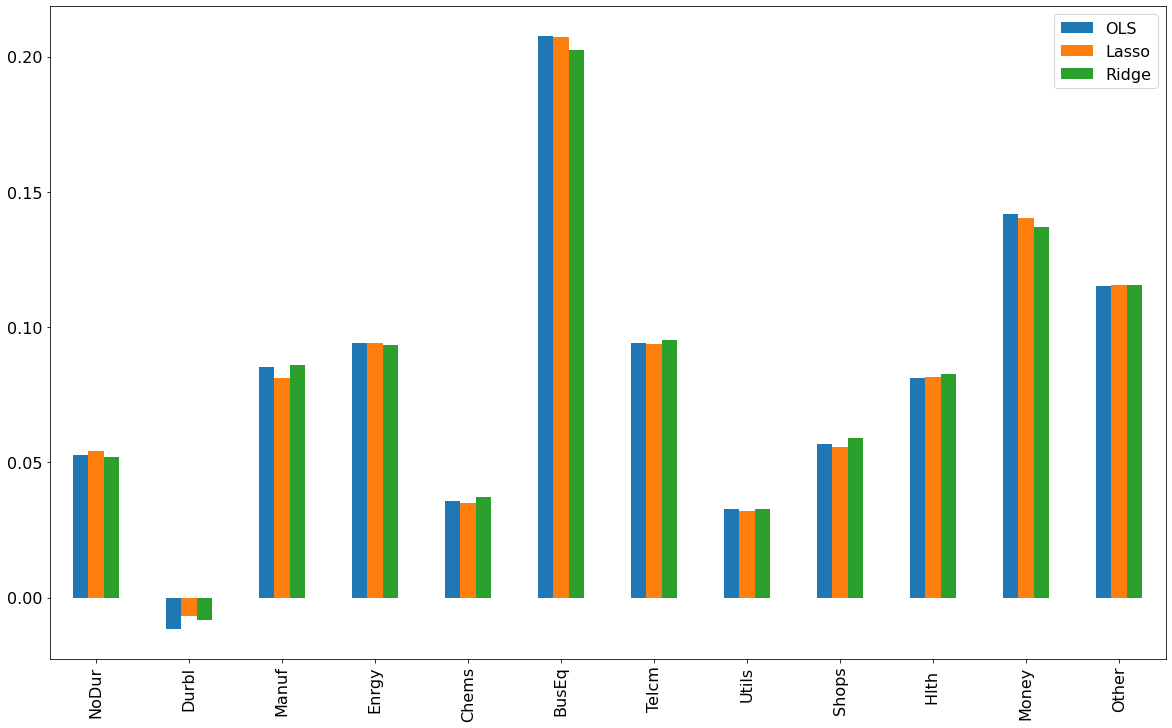

In [22]:
from statsmodels.api import OLS
import matplotlib.pyplot as plt

plt.rc("font", size=16)

ols = OLS(y,x).fit().params

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
_ = pd.DataFrame([ols, lasso_orig, ridge_orig], index=["OLS", "Lasso", "Ridge"]).T.plot(
    kind="bar", ax=ax
)

In [23]:
rescaled_pred = x @ ridge_orig
rescaled_pred

Date
1980-01-31     4.942086
1980-02-29    -1.858135
1980-03-31   -10.235365
1980-04-30     4.700443
1980-05-31     6.367643
                ...    
2014-08-31     4.011852
2014-09-30    -1.877541
2014-10-31     2.074927
2014-11-30     2.099876
2014-12-31    -0.203080
Freq: M, Length: 420, dtype: float64

### Exercise 55

Use scikit-learn to scale the standardize the data by changing the scale but not the mean.


In [33]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler(with_mean=False)
y_2d = pd.DataFrame(y)
y_scaler = y_scaler.fit(y_2d)

x_scaler = StandardScaler(with_mean=False)
x_scaler = x_scaler.fit(x)

std_y = y_scaler.transform(y_2d)
std_x = x_scaler.transform(x)

ridge_cv = RidgeCV(alphas=np.linspace(4, 6, 2001),fit_intercept=False)
ridge_cv = ridge_cv.fit(std_x, std_y)
ridge_cv.alpha_

4.87

### Exercise 56

Use the scikit-learn scaler to compute the predicted in-sample values using the Ridge ridge regression.

In [34]:
pred = ridge_cv.predict(std_x)
rescaled_pred = y_scaler.inverse_transform(pred)
pd.Series(rescaled_pred.squeeze())

0       4.942086
1      -1.858135
2     -10.235365
3       4.700443
4       6.367643
         ...    
415     4.011852
416    -1.877541
417     2.074927
418     2.099876
419    -0.203080
Length: 420, dtype: float64

### Exercise 57

Use the scalar from scikit-learn to produce out-of-sample forecasts of the two shrinkage estimators and OLS and evaluate the out-of-sample SSE.


In [38]:
# select the out of sample data
y_oos = vwm.loc["2015":,"VWM"]
x_oos = industries["2015":]

#transform the out of sample values
std_x_oos = x_scaler.transform(x_oos)

# Predict using the standardised OOS values
pred = lasso_cv.predict(std_x_oos)
# compute the OOS residuals by invertig the scale of the prediction
resid_oos = y_oos - y_scaler.inverse_transform(pred)
lasso_oos_sse = resid_oos @ resid_oos
lasso_oos_sse

19.12635954083695

In [41]:
# ridge
pred =  ridge_cv.predict(std_x_oos)
resid_oos = y_oos - y_scaler.inverse_transform(np.squeeze(pred))
ridge_oos_sse = resid_oos @ resid_oos
ridge_oos_sse

19.501831333606148

In [42]:
ols_pred = x_oos @ ols
resid_oos = y_oos - ols_pred
ols_oos_sse = resid_oos @ resid_oos
ols_oos_sse

20.150507935326225

### Exercise 58

Directly produce out-of-sample forecasts of the two shrinkage estimators and OLS and evaluate the out-of-sample SSE without using scikit-learn.


In [49]:
x_oos = industries["2015":]
direct_pred = x_oos @ ridge_orig

resid_oos = y_oos - direct_pred
ridge_oos_sse = resid_oos @ resid_oos
print(ridge_oos_sse)
print()

direct_pred = x_oos @ lasso_orig
resid_oos = y_oos - direct_pred
lasso_oos_sse = resid_oos @ resid_oos
print(lasso_oos_sse)

19.50183133359814

19.126359540836955
